# 🗞️ Task 1 – News Sentiment EDA  
📘 Version: 2025-05-29

Exploratory Data Analysis (EDA) of financial news headlines to extract publishing trends, text characteristics, and early sentiment signals for stock prediction modeling.

### This notebook covers:
- Headline length and word stats
- Publisher activity and domain extraction
- Time-based publishing patterns
- Early keyword/sentiment cues
- Cleaned export for sentiment modeling


In [1]:
# 🛠 Ensure notebook runs from project root if launched from /notebooks/
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
print("📂 Working directory is now:", os.getcwd())

expected_file = "data/raw_analyst_ratings.csv"  # Replace with actual path once confirmed
print("📄 File found" if os.path.exists(expected_file) else "🚫 File NOT found!", expected_file)


📂 Working directory is now: c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge
📄 File found data/raw_analyst_ratings.csv


In [2]:
# ------------------------------------------------------------------------------
# 📦 Core Libraries
# ------------------------------------------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------------------
# 🧠 NLP & Text Processing
# ------------------------------------------------------------------------------
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# ------------------------------------------------------------------------------
# 🔧 Display & Config
# ------------------------------------------------------------------------------
from IPython.display import display

# ------------------------------------------------------------------------------
# ⚙️ Optional: Download NLTK resources if running for first time
# ------------------------------------------------------------------------------
nltk.download("punkt")
nltk.download("stopwords")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 📥 Load Financial News Dataset

This step initializes the core dataset used throughout the EDA pipeline:

- Loads `raw_analyst_ratings.csv` from the `data/` directory.
- Automatically parses the `date` column (UTC) into a datetime format.
- Provides a clean wrapper around `pandas.read_csv()` via a modular `NewsDataLoader` class.
- Includes verbose output to verify encoding, shape, and column schema.

This ensures a robust and reproducible starting point for downstream feature engineering and sentiment modeling.


In [3]:
# ------------------------------------------------------------------------------
# 📥 Load Financial News Dataset
# ------------------------------------------------------------------------------

from src.news_loader import NewsDataLoader

# Define the dataset path (already confirmed to exist in repo)
DATA_PATH = "data/raw_analyst_ratings.csv"

# Initialize loader (auto-parses 'date' column and prints summary if verbose=True)
try:
    loader = NewsDataLoader(path=DATA_PATH)
    df = loader.load()
except Exception as e:
    print(f"❌ Failed to load dataset: {e}")
    df = None  # gracefully degrade for further diagnosis



📄 File loaded: data/raw_analyst_ratings.csv
📦 Encoding used: utf-8
🔢 Rows: 1,407,328 | Columns: 6
🧪 Columns: Unnamed: 0, headline, url, publisher, date, stock



## ✅ Initial Sanity Checks – Structure, Missingness, Duplicates

Before diving into analysis, we run a quick diagnostic to verify data health:

- Preview the top 3 rows for structural validation.
- Print full column data types to confirm schema expectations.
- Check for missing values across all columns.
- Identify and count any fully duplicated rows.

These checks help detect formatting issues or corrupt entries early, ensuring downstream feature engineering operates on clean and consistent data.


In [4]:
# ------------------------------------------------------------------------------
# ✅ Initial Sanity Check – Columns, Types, and Nulls
# ------------------------------------------------------------------------------

if df is not None:
    # Show a snapshot of the dataset
    display(df.head(3))

    # Column data types
    print("🧬 Column Data Types:")
    print(df.dtypes)

    # Check for missing values in key columns
    print("\n🔍 Missing Value Summary:")
    missing = df.isna().sum()
    print(missing[missing > 0] if missing.any() else "✅ No missing values detected.")

    # Check for duplicate rows (safety check for merge logic later)
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        print(f"⚠️ Found {duplicate_count:,} duplicate rows.")
    else:
        print("✅ No duplicate rows found.")

else:
    print("🚫 Skipping diagnostics – DataFrame not loaded.")


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A


🧬 Column Data Types:
Unnamed: 0     int64
headline      object
url           object
publisher     object
date          object
stock         object
dtype: object

🔍 Missing Value Summary:
✅ No missing values detected.
✅ No duplicate rows found.


## 🧠 Text Feature Extraction – Headline Length & Word Count

We extract basic structural features from each news headline to quantify its size and complexity:

- `headline_length`: Number of characters in the headline (includes punctuation and spaces).
- `word_count`: Total token count using NLTK’s tokenizer (handles punctuation and spacing more robustly than `.split()`).

These features provide early insight into headline density and help with both data validation and downstream modeling. They are particularly useful when identifying outliers (e.g., excessively short or clickbait-style headlines).


In [5]:
# ------------------------------------------------------------------------------
# 🧠 Text Feature Extraction – headline_length + word_count
# ------------------------------------------------------------------------------

from src.text_features import TextFeatureExtractor

# Initialize feature extractor
feature_extractor = TextFeatureExtractor(headline_col="headline", verbose=True)

# Apply transformation to compute character and word length
try:
    df = feature_extractor.transform(df)
except Exception as e:
    print(f"❌ Failed to compute text features: {e}")


✅ Text features added:
📊 Input column: 'headline'
🔠 headline_length (chars): {'count': 1407328.0, 'mean': 73.12051490484095, 'std': 40.73530993195065, 'min': 3.0, '25%': 47.0, '50%': 64.0, '75%': 87.0, 'max': 512.0}
🗨️ word_count (tokens): {'count': 1407328.0, 'mean': 13.676373240637577, 'std': 8.452906660503414, 'min': 1.0, '25%': 8.0, '50%': 12.0, '75%': 16.0, 'max': 100.0}


## 🧼 Cleaned Text Column

This step applies a configurable text cleaning pipeline to remove:
- HTML tags (e.g., `<br>`)
- Escape characters (`&amp;`)
- Punctuation
- Stopwords (e.g., "the", "and")

The result is saved as a new column `cleaned_headline` for further NLP and sentiment modeling.

In [ ]:

# ------------------------------------------------------------------------------
# 🧼 Text Cleaning – remove HTML, normalize casing, etc.
# ------------------------------------------------------------------------------

from src.text_cleaner import TextCleaner

# Initialize cleaner with common config
cleaner = TextCleaner(
    text_col="headline",
    output_col="cleaned_headline",
    lowercase=True,
    remove_html=True,
    remove_punctuation=True,
    remove_stopwords=True,
    verbose=True,
)

# Apply transformation
try:
    df = cleaner.transform(df)
except Exception as e:
    print(f"❌ Cleaning failed: {e}")


## 🔍 Bullish / Bearish Keyword Matching

Using a curated dictionary of bullish and bearish financial phrases, this step tags headlines with:
- `bullish_flag` → if the headline suggests upward market sentiment
- `bearish_flag` → if the headline suggests negative or downward sentiment

This provides an early directional signal before applying more complex sentiment scoring.


In [ ]:
# ------------------------------------------------------------------------------
# 🔍 Bullish/Bearish Keyword Flags – early sentiment indicators
# ------------------------------------------------------------------------------

from src.text_keywords import flag_bullish, flag_bearish

# Apply bullish and bearish keyword matching
try:
    df = flag_bullish(df, column="cleaned_headline")
    df = flag_bearish(df, column="cleaned_headline")
except Exception as e:
    print(f"❌ Keyword flagging failed: {e}")


✅ 'bullish_flag' added: 83,756 matches out of 1,407,328 rows
✅ 'bearish_flag' added: 71,279 matches out of 1,407,328 rows


## 📊 Headline Length & Word Count Distributions

This visualization shows the structural distribution of headlines:
- **Character Length:** Total characters per headline (`headline_length`)
- **Word Count:** Number of tokens per headline (`word_count`)

These insights help validate text normalization and highlight outliers (e.g., abnormally short or long headlines).


✅ Columns validated: headline_length, word_count
🎨 Style applied: seaborn-v0_8-muted


c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_distributions.py:150: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to prevent overlap
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


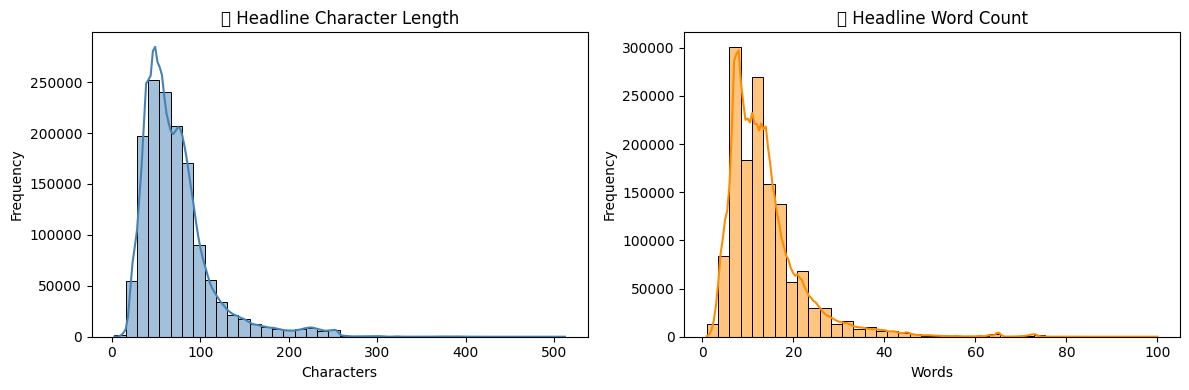

📈 Distribution plots rendered successfully.


In [ ]:
# ------------------------------------------------------------------------------  
# 📊 Visualize Headline Text Distributions – Length & Word Count  
# ------------------------------------------------------------------------------

from src.text_distributions import TextDistributionPlotter

# Initialize the plotter
plotter = TextDistributionPlotter(
    length_col="headline_length",
    word_col="word_count",
    bins=40,
    title_prefix="📝",
    style="seaborn-v0_8-muted",
    use_latex_style=False,
    verbose=True,
)

# Safely plot distribution histograms
try:
    plotter.plot(df, show=True)
except Exception as e:
    print(f"❌ Failed to render text distribution plots: {e}")


## 🏢 Publisher Frequency Analysis

Analyzes the number of headlines published by each media outlet.  
Highlights the most prolific sources in the dataset and helps assess coverage concentration or potential bias.

✅ Found 1034 unique publishers.
📈 Top 10 publishers by article count:


,publisher,article_count
0,Paul Quintaro,228373
1,Lisa Levin,186979
2,Benzinga Newsdesk,150484
3,Charles Gross,96732
4,Monica Gerson,82380
5,Eddie Staley,57254
6,Hal Lindon,49047
7,ETF Professor,28489
8,Juan Lopez,28438
9,Benzinga Staff,28114


c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_publishers.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_publishers.py:122: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


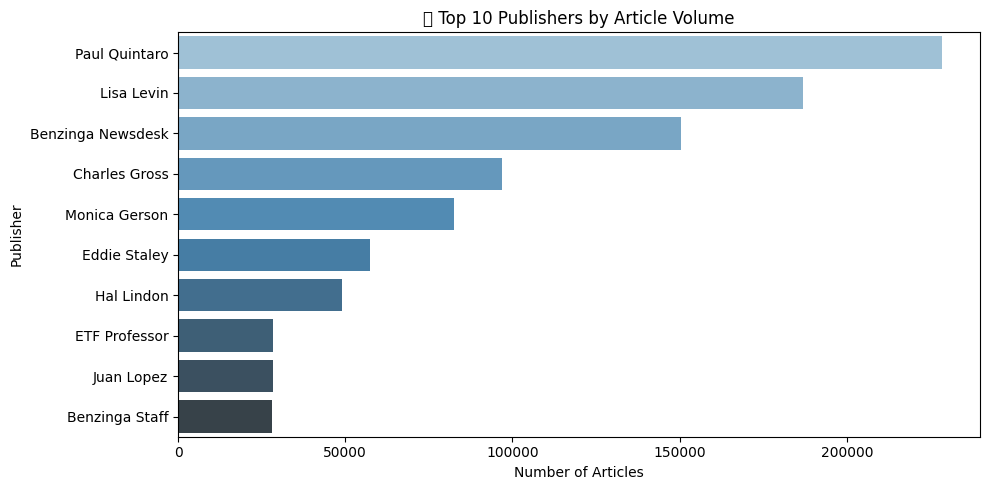

📊 Chart rendered for top 10 publishers.


In [ ]:
# ------------------------------------------------------------------------------  
# 📰 Publisher Frequency Analysis
# ------------------------------------------------------------------------------

from src.text_publishers import PublisherAnalyzer  # ✅ correct class name

# Initialize analysis object
try:
    publisher_analyzer = PublisherAnalyzer(
        publisher_col="publisher",
        verbose=True
    )

    # Analyze publisher frequency
    publisher_freq_df = publisher_analyzer.analyze(df)

    # Plot top publishers
    publisher_analyzer.plot_top_publishers(top_n=10)

except Exception as e:
    print(f"❌ Publisher frequency analysis failed: {e}")


## 🌐 Publisher Domain Extraction

Extracts and groups publisher URLs or names into standardized domain patterns (e.g., `yahoo.com`).  
Useful for identifying bots, conglomerates, and repeated sources behind different brand names.


✅ Domain analysis complete on column 'url'
🔢 1 unique domains found.
📈 Top 10 domains:


,publisher_domain,article_count
0,benzinga.com,1407328


📋 Columns in top_data: ['publisher_domain', 'article_count']
  publisher_domain  article_count
0     benzinga.com        1407328


c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_publishers_domains.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_publishers_domains.py:182: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  --------
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


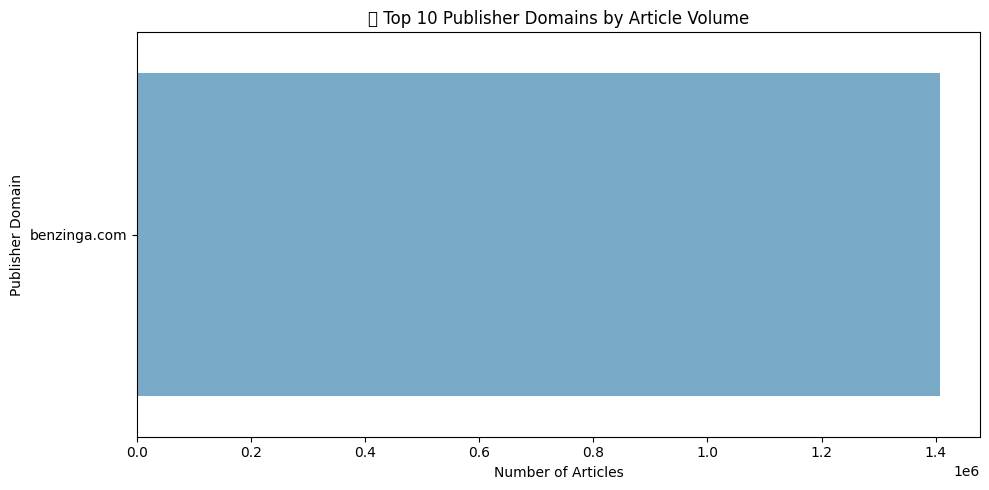

📊 Rendered bar chart for top 10 domains.


In [ ]:
# ------------------------------------------------------------------------------  
# 🌐 Publisher Domain Extraction  
# ------------------------------------------------------------------------------

from src.text_publishers_domains import PublisherDomainAnalyzer

try:
    domain_analyzer = PublisherDomainAnalyzer(
         publisher_col="url",
        domain_col="publisher_domain",
        verbose=True
    )

    # Run analysis and domain extraction
    df = domain_analyzer.analyze(df)

    # Plot top domains
    domain_analyzer.plot_top_domains(top_n=10)

except Exception as e:
    print(f"❌ Domain extraction failed: {e}")


## ⏱️ Time Series Analysis of News Volume

This section extracts:
- **Publication frequency over time** to identify periods of heavy news activity.
- **Weekday vs weekend bias** to detect institutional vs retail-driven publishing cycles.
- Useful for aligning market reactions and sentiment shifts with news density.


In [ ]:
import importlib
import src.text_time_series
importlib.reload(src.text_time_series)
from src.text_time_series import TimeSeriesTextAnalyzer


⚠️ 1351341 rows had unparseable timestamps and will be NaN.
✅ Time features added: ['date_only', 'hour', 'day_of_week', 'is_weekend']
📅 Unique dates: 2527
🕒 Publishing hours: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]


c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_time_series.py:169: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to prevent clipping
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


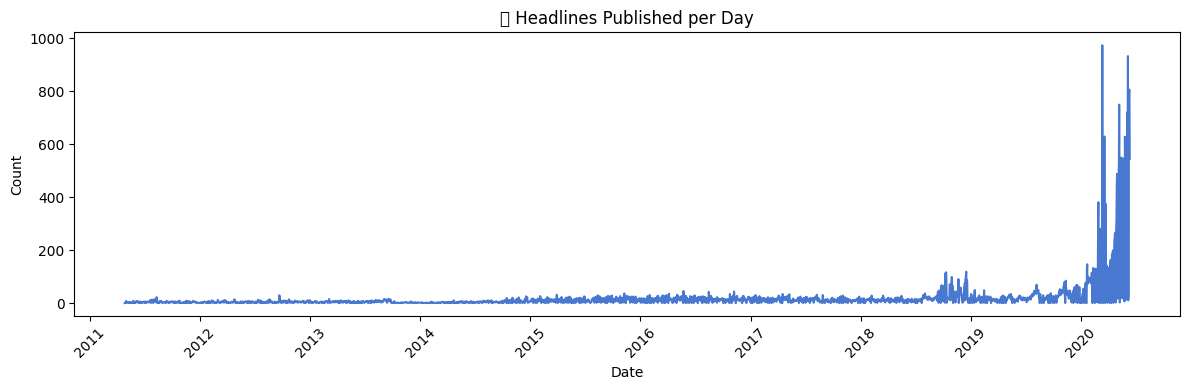

c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_time_series.py:193: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to prevent clipping
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


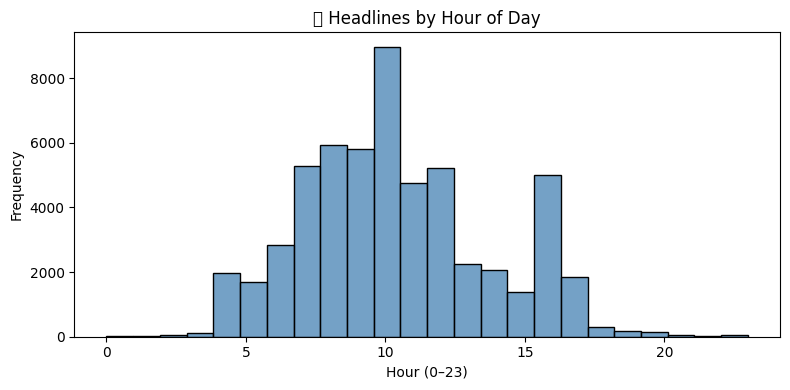

c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_time_series.py:220: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_time_series.py:226: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to prevent clipping
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


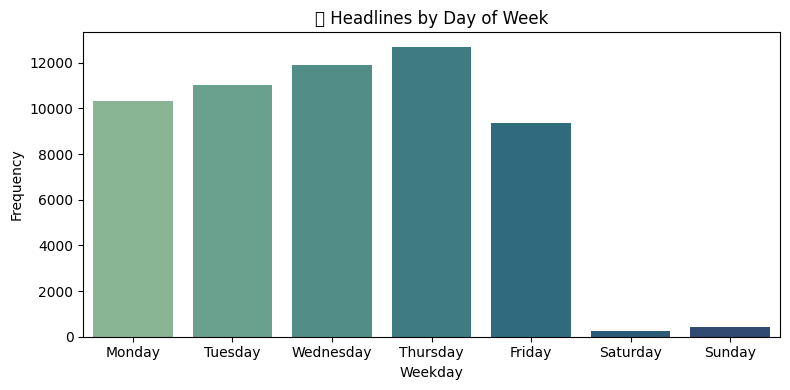

In [ ]:
# ------------------------------------------------------------------------------
# 🕒 Time Series Analysis – Publishing Frequency and Weekday Patterns
# ------------------------------------------------------------------------------

from src.text_time_series import TimeSeriesTextAnalyzer

try:
    # Initialize the analyzer with the date column
    time_analyzer = TimeSeriesTextAnalyzer(
        date_col="date",  # ISO-formatted UTC date from loader
        verbose=True,
    )

    # Apply time-based feature engineering and visualization
    df = time_analyzer.transform(df) # Adds 'day_of_week' and 'hour_of_day'
    time_analyzer.plot(df) # Plots publishing frequency by day and hour

except Exception as e:
    print(f"❌ Time series analysis failed: {e}")


In [ ]:
df